In [1]:
from torch.nn import Sequential
from torch.nn import Linear, Dropout, ReLU
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import MSELoss, HuberLoss
from torch.optim import SGD, Adam

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import json
import os

from Module.MySQL_connector import MySQLConnector
from Module.feature_selector_tree import feature_selector

In [2]:
import torch
from torch.optim import SGD
from torchmetrics import R2Score  # 引入 torchmetrics

class SimpleTrainer:
    """A model trainer for regression models."""

    def __init__(self, model, loss_fn, optimizer):
        self.model = self.to_gpu(model)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.r2_metric = R2Score().to("cuda:0")  # 初始化 R2Score

    def to_gpu(self, obj, device="cuda:0"):
        """將張量或模型送至GPU。"""
        return obj.to(device)

    def train_step(self, dataloader):
        """訓練一個epoch，並計算 R²。"""
        self.model.train()  # 設定成訓練模式
        total_loss = 0  # 累積所有 batch 的損失
        total_r2 = 0  # 累積所有 batch 的 R²

        for iteration, (batch_x, batch_y) in enumerate(dataloader):
            batch_x = self.to_gpu(batch_x)
            batch_y = self.to_gpu(batch_y)

            self.optimizer.zero_grad()  # 清空模型內所有權重的梯度

            pred_y = self.model(batch_x)  # 正向傳遞得到模型預測
              # 去掉多餘的維度
            pred_y = pred_y.squeeze(-1)
            loss_value = self.loss_fn(pred_y, batch_y)  # 計算損失

            loss_value.backward()  # 反向傳遞
            self.optimizer.step()  # 更新權重

            total_loss += loss_value.item()  # 累積損失
            
            # 使用 torchmetrics 計算 R²
            r2 = self.r2_metric(pred_y, batch_y)
            total_r2 += r2.item()

        avg_loss = total_loss / len(dataloader)  # 計算平均損失
        avg_r2 = total_r2 / len(dataloader)  # 平均 R²
        print(f"Train loss: {avg_loss:.4f}, Train R²: {avg_r2:.4f}")
        return avg_loss, avg_r2

    def test_step(self, dataloader, mode="test"):
        """結束一個epoch的訓練後，測試模型表現。"""
        self.model.eval()  # 設定成推理模式

        test_loss = 0
        total_r2 = 0

        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x = self.to_gpu(batch_x)
                batch_y = self.to_gpu(batch_y)

                pred_y = self.model(batch_x)
                pred_y = pred_y.squeeze(-1)
                # 计算损失
                test_loss += self.loss_fn(pred_y, batch_y).item()

                # 使用 torchmetrics 計算 R²
                r2 = self.r2_metric(pred_y, batch_y)
                total_r2 += r2.item()

        avg_test_loss = test_loss / len(dataloader)  # 計算平均測試損失
        avg_r2 = total_r2 / len(dataloader)  # 平均 R²
        print(f"{mode}_loss={avg_test_loss:.4f}, {mode}_R²={avg_r2:.4f}")
        return avg_test_loss, avg_r2

    def fit(self, dataloader_train, dataloader_test, num_epochs):
        # 開始訓練
        metrics = {"train_loss": [], "test_loss": [], "train_r2": [], "test_r2": []}
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            train_loss, train_r2 = self.train_step(dataloader_train)
            test_loss, test_r2 = self.test_step(dataloader_test)

            metrics["train_loss"].append(train_loss)
            metrics["test_loss"].append(test_loss)
            metrics["train_r2"].append(train_r2)
            metrics["test_r2"].append(test_r2)
        
        return metrics

    def __call__(self, x):
        self.model.eval()  # 啟動推理模式
        return self.model(x)  # 執行推理


In [3]:
raw_table = pd.read_csv("../../data/processed/full_data_for_ml.csv")
raw_table = raw_table.drop(columns=["Unnamed: 0","steamId"])

In [5]:
raw_table

,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Accounting,Action,Adventure,Animation & Modeling,...,Steam Timeline,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled,indie
0,8.404149,0.453316,0.587113,0.466248,0.451984,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
1,13.475520,0.762018,0.493235,0.227723,0.647464,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,True
2,6.207449,0.333886,0.521493,0.000000,0.337546,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
3,3.663562,0.450807,0.620089,0.166560,0.451984,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
4,11.548621,0.762480,0.829376,0.073704,0.573996,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17785,3.610918,0.000000,0.186124,0.656380,0.129757,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,True
17786,4.343805,0.234036,0.347340,0.479719,0.260932,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17787,7.483244,0.271885,0.492761,0.125998,0.303104,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17788,2.772589,0.214907,0.398674,0.498221,0.337546,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True


In [ ]:
from sklearn.model_selection import train_test_split

# full_table = feature_selector(raw_table,8)
X_full = full_table.drop(columns="sales").values
Y_full = full_table['sales'].values
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.2, random_state = 42)
print(X_train_full.dtype)
print(y_train_full.dtype)
X_train_full = np.array(X_train_full, dtype=np.float32)
y_train_full = np.array(y_train_full, dtype=np.float32)
X_test_full = np.array(X_test_full, dtype=np.float32)
y_test_full = np.array(y_test_full, dtype=np.float32)
print(X_train_full.dtype)
print(y_train_full.dtype)
X_full.shape[1]


train Mean Squared Error (MSE): 2.1859333682085014
train R-squared (R²): 0.637696923534935
test Mean Squared Error (MSE): 2.542588147825996
test R-squared (R²): 0.5868922938205223
Level 1: ['medianRevenue']
Level 2: ['medianRevenue']
Level 3: ['Steam Achievements', 'Profile Features Limited', 'medianRevenue']
Level 4: ['publishedGames', 'Profile Features Limited', 'price', 'medianRevenue']
Level 5: ['Profile Features Limited', 'medianRevenue', 'averageRevenue', 'Steam Trading Cards', 'publishedGames', 'NSFW', 'RPG', 'price', 'Board Game', 'Roguelite', 'Steam Cloud']
Level 6: ['medianRevenue', '3D', 'Shooter', 'Realistic', '2D', 'price', 'publishedGames', 'Horror', 'Steam Achievements', 'America', 'Steam Trading Cards', 'Great Soundtrack', 'Psychological Horror', 'averageRevenue', 'Runner', 'Nonlinear', 'Motorbike', 'Online Co-op', 'Family Friendly', 'Singleplayer', "Shoot 'Em Up"]
Level 7: ['Lore-Rich', 'Grid-Based Movement', 'medianRevenue', 'Difficult', 'earlyAccess', 'Survival', 'Cl

109

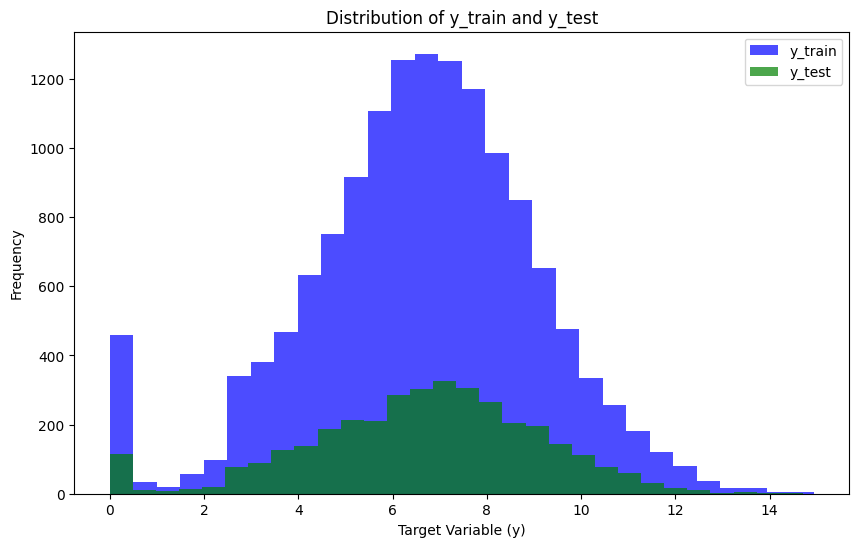

In [88]:
import matplotlib.pyplot as plt

# 當 y_train 和 y_test 定義後，可以使用如下代碼繪製圖表

plt.figure(figsize=(10,6))

# 繪製 y_train 的分布
plt.hist(y_train_full, bins=30, alpha=0.7, label='y_train', color='blue')

# 繪製 y_test 的分布
plt.hist(y_test_full, bins=30, alpha=0.7, label='y_test', color='green')

# 添加標籤和標題
plt.xlabel('Target Variable (y)')
plt.ylabel('Frequency')
plt.title('Distribution of y_train and y_test')
plt.legend()

# 顯示圖表
plt.show()

In [141]:
from sklearn.model_selection import train_test_split

full_table = feature_selector(raw_table,8)
X_full = full_table.drop(columns="sales").values
Y_full = full_table['sales'].values
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.2, random_state = 42)

X_train_full = np.array(X_train_full, dtype=np.float32)
y_train_full = np.array(y_train_full, dtype=np.float32)
X_test_full = np.array(X_test_full, dtype=np.float32)
y_test_full = np.array(y_test_full, dtype=np.float32)

x_train, y_train = torch.tensor(X_train_full), torch.tensor(y_train_full)
x_test, y_test = torch.tensor(X_test_full), torch.tensor(y_test_full)
x_train = x_train.to(torch.float32)
x_test = x_test.to(torch.float32)
y_train = y_train.to(torch.float32)
y_test = y_test.to(torch.float32)
# 將PyTorch tensor 製作成 Data Loader
td = TensorDataset(x_train, y_train)
dl_train = DataLoader(td, batch_size=512, shuffle=True)
# Shuffle 隨機打亂數據，防止模型過度依賴數據的順序，從而提高模型的泛化能力。
td = TensorDataset(x_test, y_test)
dl_test = DataLoader(td, batch_size=512, shuffle=False)
input_size=X_full.shape[1]

train Mean Squared Error (MSE): 2.1859333682085014
train R-squared (R²): 0.637696923534935
test Mean Squared Error (MSE): 2.5323783551074714
test R-squared (R²): 0.58855113269072
Level 1: ['medianRevenue']
Level 2: ['medianRevenue']
Level 3: ['Steam Achievements', 'Profile Features Limited', 'medianRevenue']
Level 4: ['publishedGames', 'Profile Features Limited', 'price', 'medianRevenue']
Level 5: ['Profile Features Limited', 'medianRevenue', 'averageRevenue', 'Steam Trading Cards', 'publishedGames', 'NSFW', 'RPG', 'price', 'Board Game', 'Roguelite', 'Steam Cloud']
Level 6: ['medianRevenue', '3D', 'Shooter', 'Realistic', '2D', 'price', 'publishedGames', 'Horror', 'Steam Achievements', 'Archery', 'Steam Trading Cards', 'Great Soundtrack', 'Psychological Horror', 'averageRevenue', 'Runner', 'Nonlinear', 'Motorbike', 'Online Co-op', 'Family Friendly', 'Singleplayer', "Shoot 'Em Up"]
Level 7: ['Lore-Rich', 'Grid-Based Movement', 'medianRevenue', 'Difficult', 'Agriculture', 'Survival', 'Cla

In [80]:
for x_batch, y_batch in dl_train:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([512, 58]) torch.Size([512])


In [90]:
print(f"Shape of X_train:{X_train_full.shape}")
print(f"Shape of X_test:{X_test_full.shape}")
print(f"Shape of y_train:{y_train_full.shape}")
print(f"Shape of y_test{y_test_full.shape}")

Shape of X_train:(14232, 111)
Shape of X_test:(3558, 111)
Shape of y_train:(14232,)
Shape of y_test(3558,)


In [5]:
def reset_model_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
from torch import nn
layers = [ 
    Linear(111, 1024),  # 增加神經元數量
    ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(p=0.5),
    Linear(1024, 512),
    ReLU(),# 增加一層
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.5),
    Linear(512, 256),
    ReLU(),
    nn.BatchNorm1d(256),
    # nn.Dropout(p=0.5),
    Linear(256, 1)
]


In [ ]:

# 宣告模型訓練設定
num_epochs = 1500
learning_rate = 0.005
model = Sequential(*layers)
reset_model_weights(model)
# 定義優化器, Loss函數
loss = MSELoss()
# loss= torch.nn.SmoothL1Loss()
opt = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# 開始訓練模|型

model = SimpleTrainer(model, loss, opt)
metrics = model.fit(dl_train, dl_test, num_epochs=num_epochs)

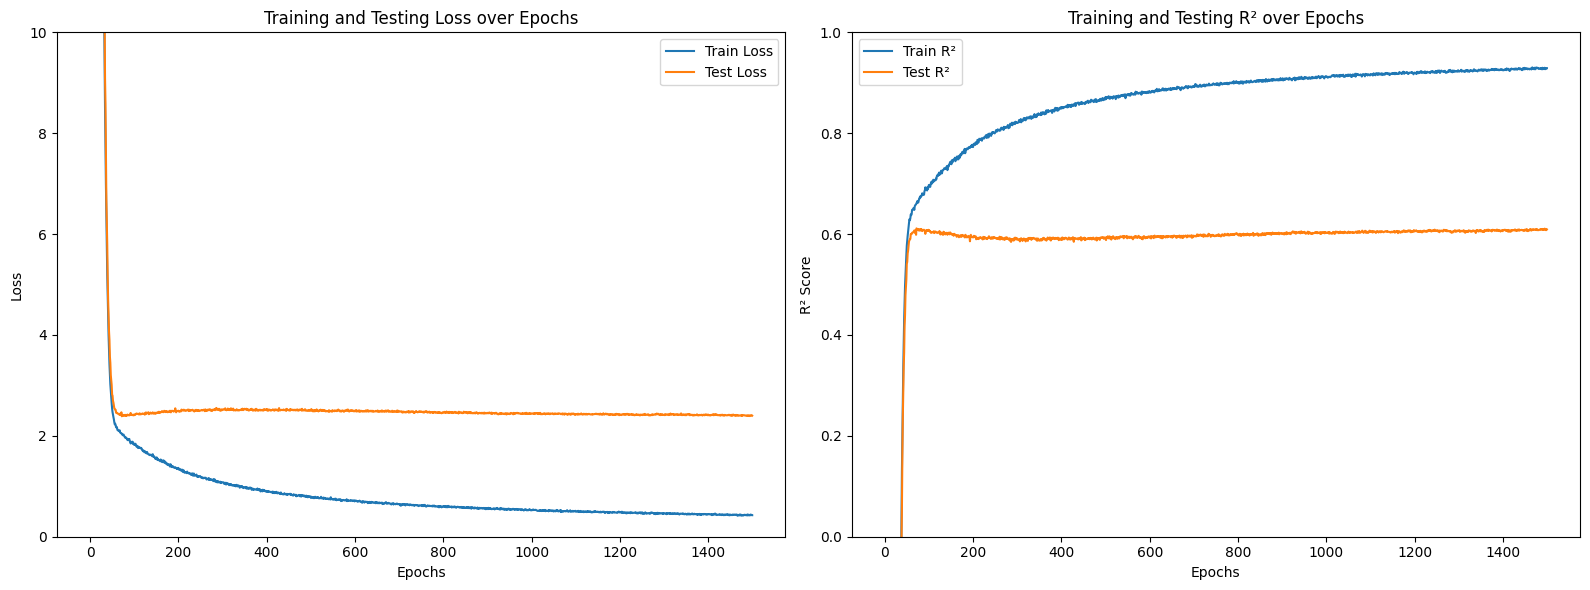

In [93]:
import matplotlib.pyplot as plt

# 假设 metrics 字典已经有 'train_loss' 和 'test_loss'
# 这些是从 trainer.fit() 返回的
train_loss = metrics["train_loss"]
test_loss = metrics["test_loss"]
train_r2 = metrics["train_r2"]
test_r2 = metrics["test_r2"]

# 創建兩個子圖：一個顯示損失，另一個顯示 R²
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# 第一張圖：訓練損失和測試損失
axs[0].plot(train_loss, label="Train Loss")
axs[0].plot(test_loss, label="Test Loss")
axs[0].set_title("Training and Testing Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim(0, 10)
axs[0].legend()

# 第二張圖：訓練 R² 和測試 R²
axs[1].plot(train_r2, label="Train R²")
axs[1].plot(test_r2, label="Test R²")
axs[1].set_title("Training and Testing R² over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("R² Score")
axs[1].set_ylim(0, 1)
# axs[1].set_xlim(0, 500)
axs[1].legend()

# 顯示圖表
plt.tight_layout()
plt.show()


In [9]:
def create_model(hidden_layers, hidden_units, dropout_rate, input_size):
    layers = [ 
        nn.Linear(input_size, 1024),  # 輸入層
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(p=dropout_rate),  # 使用可調整的 dropout rate
    ]

    # 動態添加隱藏層
    in_features = 1024
    for _ in range(hidden_layers):
        layers.append(nn.Linear(in_features, hidden_units))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_units))
        layers.append(nn.Dropout(p=dropout_rate))
        in_features = hidden_units

    # 輸出層
    layers.append(nn.Linear(in_features, 1))
    
    return nn.Sequential(*layers)

## 1. Grid search 超參數調整參

In [104]:
param_grid = {
    'hidden_layers': [2, 3, 4],  # 隱藏層數
    'hidden_units': [256, 512],  # 每層的神經元數量
    'dropout_rate': [0.1, 0.3, 0.5],  # Dropout 概率
    'learning_rate': [0.0001,0.0005,0.001, 0.005]  # 學習率
}

In [12]:
import itertools
from torch.optim import Adam
from torch.nn import MSELoss
from sklearn.metrics import mean_squared_error
import torch

In [116]:
import itertools
from torch.optim import Adam
from torch.nn import MSELoss
from sklearn.metrics import mean_squared_error
import torch


best_mse = float('inf')
best_params = None

# 遍歷所有超參數的組合
for hidden_layers, hidden_units, dropout_rate, learning_rate in itertools.product(
        param_grid['hidden_layers'], 
        param_grid['hidden_units'], 
        param_grid['dropout_rate'], 
        param_grid['learning_rate']):
    
    print(f"訓練模型: hidden_layers={hidden_layers}, hidden_units={hidden_units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
    
    # 創建模型
    model = create_model(hidden_layers=hidden_layers, hidden_units=hidden_units, dropout_rate=dropout_rate)
    
    # 定義優化器和損失函數
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    loss_fn = MSELoss()

    # 使用 SimpleTrainer 進行訓練
    trainer = SimpleTrainer(model, loss_fn, optimizer)
    metrics = trainer.fit(dl_train, dl_test, num_epochs=100)  # 使用自定義的 SimpleTrainer 進行訓練
    
    # print(f"test_loss={metrics["test_loss"][-1]:.4f}, test_R²={metrics["test_r2"][-1]:.4f}")
    # 從 metrics 中獲取最後一個 epoch 的測試集 MSE
    test_mse = metrics["test_loss"][-1]  # 這裡已經是 MSE，因為 loss_fn 是 MSELoss
    print(f"Test MSE: {test_mse}")
    test_R2 = metrics["test_r2"][-1] 
    print(f"test_loss={test_mse:.4f}, test_R²={test_R2:.4f}")
    # 保存最佳參數組合
    if test_mse < best_mse:
        best_mse = test_mse
        best_params = {
            'hidden_layers': hidden_layers,
            'hidden_units': hidden_units,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate
        }
        best_R2 = test_R2

# 輸出最佳參數和對應的 MSE
print(f"最佳參數: {best_params}")
print(f"最低 Test MSE: {best_mse}, R2: {best_R2}")



訓練模型: hidden_layers=2, hidden_units=256, dropout_rate=0.1, learning_rate=0.0001
Test MSE: 2.8370516981397356
test_loss=2.8371, test_R²=0.5383
訓練模型: hidden_layers=2, hidden_units=256, dropout_rate=0.1, learning_rate=0.0005
Test MSE: 2.6242298739297047
test_loss=2.6242, test_R²=0.5729
訓練模型: hidden_layers=2, hidden_units=256, dropout_rate=0.1, learning_rate=0.001
Test MSE: 2.588444471359253
test_loss=2.5884, test_R²=0.5788
訓練模型: hidden_layers=2, hidden_units=256, dropout_rate=0.1, learning_rate=0.005
Test MSE: 2.698763268334525
test_loss=2.6988, test_R²=0.5607
訓練模型: hidden_layers=2, hidden_units=256, dropout_rate=0.3, learning_rate=0.0001
Test MSE: 2.6605395589556013
test_loss=2.6605, test_R²=0.5666
訓練模型: hidden_layers=2, hidden_units=256, dropout_rate=0.3, learning_rate=0.0005
Test MSE: 2.5754852976117815
test_loss=2.5755, test_R²=0.5808
訓練模型: hidden_layers=2, hidden_units=256, dropout_rate=0.3, learning_rate=0.001
Test MSE: 2.5468758174351285
test_loss=2.5469, test_R²=0.5854
訓練模型: hidde

In [ ]:
param_grid = {
    'hidden_layers': [2, 3, 4],  # 隱藏層數
    'hidden_units': [256, 512, 2048],  # 每層的神經元數量
    'dropout_rate': [0.3, 0.5],  # Dropout 概率
    'learning_rate': [0.0001,0.0005,0.001, 0.005]  # 學習率
}

## 2. Optuna 調參


In [8]:
from sklearn.model_selection import train_test_split

def load_dataset(raw_table, batch_size, tree_depth):
    # full_table = feature_selector(raw_table,tree_depth)
    full_table = raw_table
    X_full = full_table.drop(columns="sales").values
    Y_full = full_table['sales'].values
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.2, random_state = 42)

    X_train_full = np.array(X_train_full, dtype=np.float32)
    y_train_full = np.array(y_train_full, dtype=np.float32)
    X_test_full = np.array(X_test_full, dtype=np.float32)
    y_test_full = np.array(y_test_full, dtype=np.float32)

    x_train, y_train = torch.tensor(X_train_full), torch.tensor(y_train_full)
    x_test, y_test = torch.tensor(X_test_full), torch.tensor(y_test_full)
    x_train = x_train.to(torch.float32)
    x_test = x_test.to(torch.float32)
    y_train = y_train.to(torch.float32)
    y_test = y_test.to(torch.float32)
    # 將PyTorch tensor 製作成 Data Loader
    td = TensorDataset(x_train, y_train)
    dl_train = DataLoader(td, batch_size=batch_size, shuffle=True)
    # Shuffle 隨機打亂數據，防止模型過度依賴數據的順序，從而提高模型的泛化能力。
    td = TensorDataset(x_test, y_test)
    dl_test = DataLoader(td, batch_size=batch_size, shuffle=False)
    input_size=X_full.shape[1]
    return dl_train, dl_test, input_size

In [ ]:
import optuna
import logging
from torch import nn
from torch.optim import Adam
from torch.nn import MSELoss


# 設定 logging 模組來輸出到 log 檔案和控制台
logging.basicConfig(
    filename='optuna_tuning_103124-2.log', 
    filemode='a',  # 'a' 表示追加模式，可以不覆蓋已有的日誌
    level=logging.INFO,  # 設置日誌級別
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# 將 Optuna 的日誌輸出設定為使用 logging 模組
# optuna.logging.enable_propagation()  # 啟用日誌向上傳遞
# optuna.logging.disable_default_handler()  # 禁用 Optuna 的默認日誌處理器

# 定義目標函數 (objective function)
def objective(trial):
    
    # 超參數範圍設置
    hidden_layers = trial.suggest_int("hidden_layers", 1, 4)  # 隱藏層數量
    hidden_units = trial.suggest_categorical("hidden_units", [128, 256, 512,1024])  # 每層的神經元數量
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.8)  # Dropout 概率
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  # 使用 suggest_float 代替 suggest_loguniform
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512, 1024]) 
    tree_depth = trial.suggest_int("tree_depth", 6, 12)
    # 創建模型
    dl_train, dl_test, input_size = load_dataset(raw_table, batch_size, tree_depth)
    model = create_model(hidden_layers=hidden_layers, hidden_units=hidden_units, dropout_rate=dropout_rate, input_size=input_size)
    
    # 定義優化器和損失函數
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_fn = MSELoss()

    # 使用 SimpleTrainer 進行訓練
    trainer = SimpleTrainer(model, loss_fn, optimizer)
    metrics = trainer.fit(dl_train, dl_test, num_epochs=100)

    # 返回測試集的最後一個 epoch 的 MSE 作為目標函數的值
    test_mse = metrics["test_loss"][-1]  # 這裡已經是 MSE，因為 loss_fn 是 MSELoss
    # 計算 R² 值
    test_r2 = metrics["test_r2"][-1]  # 假設 metrics 中有 R² 記錄
    train_mse = metrics["train_loss"][-1]
    train_r2 = metrics["train_r2"][-1]
    # 打印 R² 值
    print(f"Parameters: {trial.params}")
    print(f"Trial {trial.number}: Train MSE={train_mse}, Train R²={train_r2}")
    print(f"Trial {trial.number}: Test MSE={test_mse}, Test R²={test_r2}")
    logging.info(f"Parameters: {trial.params}")
    logging.info(f"Trial {trial.number}: Train MSE={train_mse}, Train R²={train_r2}")
    logging.info(f"Trial {trial.number}: Test MSE={test_mse}, Test R²={test_r2}")
    logging.info("=" * 300)
    return test_mse

# 使用 Optuna 進行超參數優化
study = optuna.create_study(direction="minimize")  # 我們要最小化 MSE
study.optimize(objective, n_trials=50)  # 進行 100 次優化

# 輸出最佳參數和最小 MSE
# study.
print(f"最佳參數: {study.best_params}")
print(f"最低 MSE: {study.best_value}")
logging.info(f"最佳參數: {study.best_params}")
logging.info(f"最低 MSE: {study.best_value}")

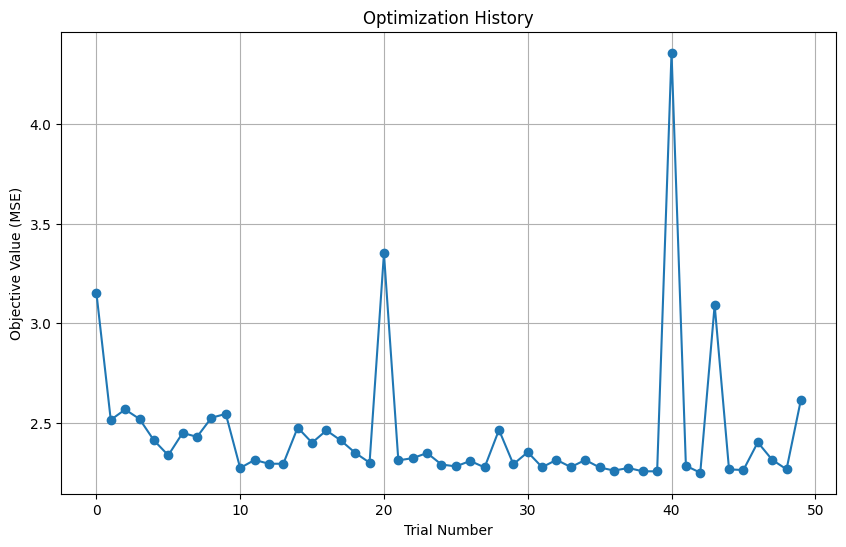

In [11]:
import matplotlib.pyplot as plt

# 提取所有試驗的目標值
trial_numbers = [trial.number for trial in study.trials]
values = [trial.value for trial in study.trials]

plt.figure(figsize=(10, 6))
plt.plot(trial_numbers, values, marker="o")
plt.xlabel("Trial Number")
plt.ylabel("Objective Value (MSE)")
plt.title("Optimization History")
plt.grid(True)
plt.show()


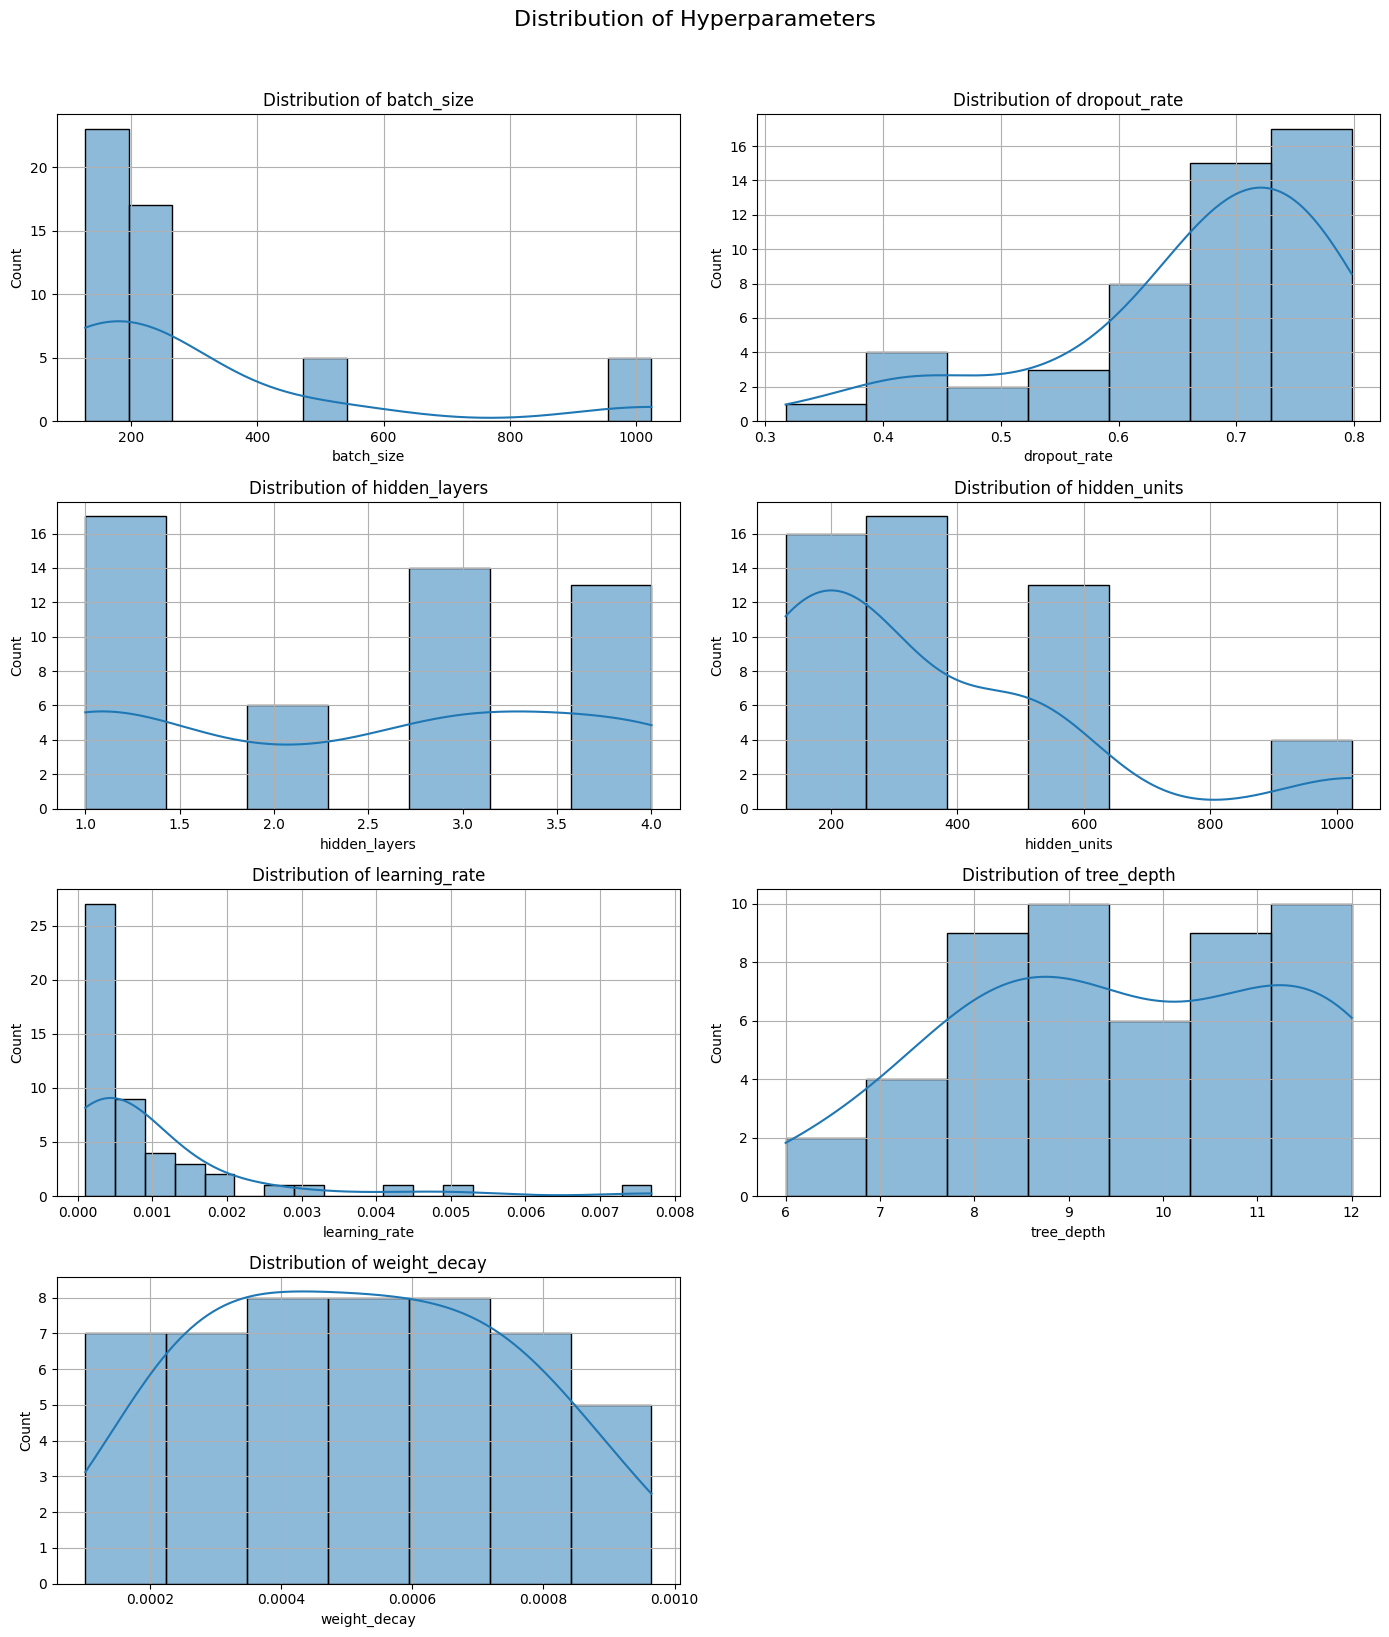

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 將試驗結果轉為 DataFrame 格式
df = study.trials_dataframe(attrs=("number", "value", "params"))
params = df.filter(like="params_")

# 設定子圖的行數和列數
num_params = len(params.columns)
fig, axes = plt.subplots(nrows=(num_params // 2 + num_params % 2), ncols=2, figsize=(14, 4 * (num_params // 2 + num_params % 2)))
fig.suptitle("Distribution of Hyperparameters", y=1.02, fontsize=16)

# 遍歷每個參數並繪製到對應的子圖中
for i, col in enumerate(params.columns):
    ax = axes[i // 2, i % 2]  # 確定子圖位置
    sns.histplot(params[col], kde=True, ax=ax)
    ax.set_xlabel(col.replace("params_", ""))
    ax.set_title(f"Distribution of {col.replace('params_', '')}")
    ax.grid(True)

# 如果參數數量是奇數，移除最後一個空白子圖
if num_params % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


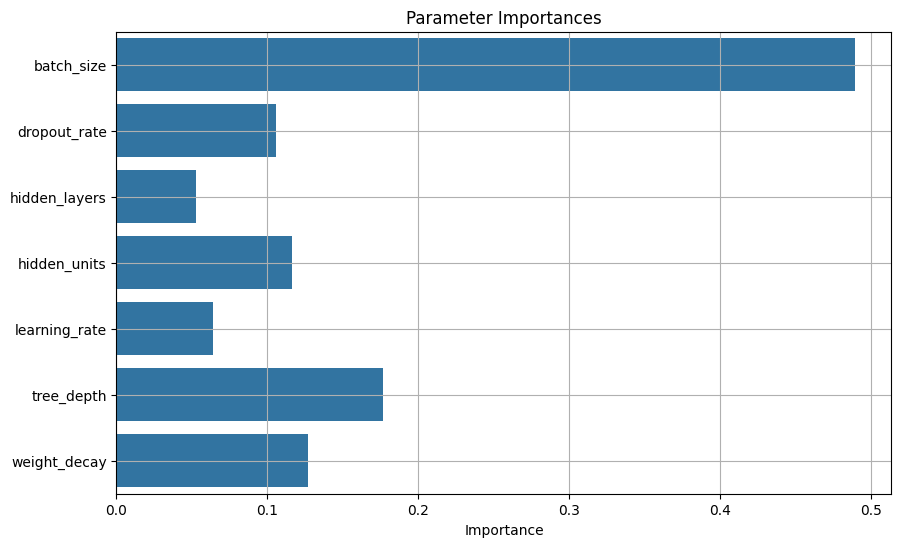

In [13]:
import numpy as np

# 簡單的參數重要性計算（例如使用參數對目標值的變異性）
importance = {}
for col in params.columns:
    # 使用絕對相關性來衡量參數重要性
    importance[col.replace("params_", "")] = np.abs(np.corrcoef(params[col], df["value"])[0, 1])

# 繪製參數重要性
plt.figure(figsize=(10, 6))
sns.barplot(x=list(importance.values()), y=list(importance.keys()))
plt.xlabel("Importance")
plt.title("Parameter Importances")
plt.grid(True)
plt.show()

In [11]:
import optuna
import logging
from torch import nn
from torch.optim import Adam
from torch.nn import MSELoss

c:\Users\Nico\anaconda3\envs\dev310-mldl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 根據前一輪optuna結果優化參數範圍

In [ ]:


# 設定 logging 模組來輸出到 log 檔案和控制台
logging.basicConfig(
    filename='optuna_tuning_103124-2.log', 
    filemode='a',  # 'a' 表示追加模式，可以不覆蓋已有的日誌
    level=logging.INFO,  # 設置日誌級別
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# 將 Optuna 的日誌輸出設定為使用 logging 模組
# optuna.logging.enable_propagation()  # 啟用日誌向上傳遞
# optuna.logging.disable_default_handler()  # 禁用 Optuna 的默認日誌處理器

# 定義目標函數 (objective function)
def objective(trial):
    
    # 超參數範圍設置
    # 保留最佳的 weight_decay 和 batch_size
    weight_decay = 0.00024797053276969004
    batch_size = 512

    # 縮小其餘參數範圍
    hidden_layers = trial.suggest_int("hidden_layers", 1, 2)  # 假設範圍仍為 1 到 4
    hidden_units = trial.suggest_categorical("hidden_units", [192, 256, 320])  # 保留原範圍
    dropout_rate = trial.suggest_float("dropout_rate", 0.75, 0.85)  # 在 0.799 附近微調
    learning_rate = trial.suggest_float("learning_rate", 0.005, 0.006, log=True)  # 調整到 0.005 到 0.006 之間
    tree_depth = trial.suggest_int("tree_depth", 11, 13)  # 圍繞最佳值微調
    
    # 創建模型
    dl_train, dl_test, input_size = load_dataset(raw_table, batch_size, tree_depth)
    model = create_model(hidden_layers=hidden_layers, hidden_units=hidden_units, dropout_rate=dropout_rate, input_size=input_size)
    
    # 定義優化器和損失函數
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_fn = MSELoss()

    # 使用 SimpleTrainer 進行訓練
    trainer = SimpleTrainer(model, loss_fn, optimizer)
    metrics = trainer.fit(dl_train, dl_test, num_epochs=100)

    # 返回測試集的最後一個 epoch 的 MSE 作為目標函數的值
    test_mse = metrics["test_loss"][-1]  # 這裡已經是 MSE，因為 loss_fn 是 MSELoss
    # 計算 R² 值
    test_r2 = metrics["test_r2"][-1]  # 假設 metrics 中有 R² 記錄
    train_mse = metrics["train_loss"][-1]
    train_r2 = metrics["train_r2"][-1]
    # 打印 R² 值
    print(f"Parameters: {trial.params}")
    print(f"Trial {trial.number}: Train MSE={train_mse}, Train R²={train_r2}")
    print(f"Trial {trial.number}: Test MSE={test_mse}, Test R²={test_r2}")
    logging.info(f"Parameters: {trial.params}")
    logging.info(f"Trial {trial.number}: Train MSE={train_mse}, Train R²={train_r2}")
    logging.info(f"Trial {trial.number}: Test MSE={test_mse}, Test R²={test_r2}")
    logging.info("=" * 300)
    return test_mse

# 使用 Optuna 進行超參數優化
study = optuna.create_study(direction="minimize")  # 我們要最小化 MSE
study.optimize(objective, n_trials=1000)  # 進行 100 次優化

# 輸出最佳參數和最小 MSE
# study.
print(f"最佳參數: {study.best_params}")
print(f"最低 MSE: {study.best_value}")
logging.info(f"最佳參數: {study.best_params}")
logging.info(f"最低 MSE: {study.best_value}")

In [215]:
test_table = pd.read_csv("../../data/processed/full_data_for_ml.csv").drop(columns=["Unnamed: 0","steamId"])
test_table
# raw_table

,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Accounting,Action,Adventure,Animation & Modeling,...,Steam Timeline,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled,indie
0,8.404149,0.453316,0.587113,0.466248,0.451984,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
1,13.475520,0.762018,0.493235,0.227723,0.647464,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,True
2,6.207449,0.333886,0.521493,0.000000,0.337546,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
3,3.663562,0.450807,0.620089,0.166560,0.451984,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
4,11.548621,0.762480,0.829376,0.073704,0.573996,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17785,3.610918,0.000000,0.186124,0.656380,0.129757,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,True
17786,4.343805,0.234036,0.347340,0.479719,0.260932,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17787,7.483244,0.271885,0.492761,0.125998,0.303104,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17788,2.772589,0.214907,0.398674,0.498221,0.337546,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True


In [214]:
raw_table = pd.read_csv("../../data/processed/raw_table_mldl.csv").drop(columns=["Unnamed: 0","steamId"])
# raw_table["sales"] = test_table["sales"]
raw_table["averageRevenue"] = test_table["averageRevenue"]
raw_table["medianRevenue"] = test_table["medianRevenue"]
raw_table["publishedGames"] = test_table["publishedGames"]
# raw_table['price'] = np.log1p(raw_table['price'])
raw_table["price"] = test_table["price"]

In [216]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

# 将 'price' 列转换为 numpy 数组并重塑为二维数组
sales_values = test_table["sales"].values.reshape(-1, 1)

# 对 'price_values' 进行缩放
raw_table["sales"] = scaler.fit_transform(sales_values)


In [6]:
raw_table

,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Accounting,Action,Adventure,Animation & Modeling,...,Steam Timeline,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled,indie
0,8.404149,0.453316,0.587113,0.466248,0.451984,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
1,13.475520,0.762018,0.493235,0.227723,0.647464,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,True
2,6.207449,0.333886,0.521493,0.000000,0.337546,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
3,3.663562,0.450807,0.620089,0.166560,0.451984,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
4,11.548621,0.762480,0.829376,0.073704,0.573996,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17785,3.610918,0.000000,0.186124,0.656380,0.129757,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,True
17786,4.343805,0.234036,0.347340,0.479719,0.260932,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17787,7.483244,0.271885,0.492761,0.125998,0.303104,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
17788,2.772589,0.214907,0.398674,0.498221,0.337546,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True


In [12]:

# 保留最佳的超參數
best_para = {'hidden_layers': 1, 
             'hidden_units': 320, 
             'dropout_rate': 0.8450569460998046, 
             'learning_rate': 0.005221932445598954, 
             'tree_depth': 13
        }
weight_decay = 0.00024797053276969004
batch_size = 512
hidden_layers = best_para["hidden_layers"]
hidden_units = best_para["hidden_units"]
dropout_rate = best_para["dropout_rate"]
learning_rate = best_para["learning_rate"]
tree_depth = best_para["tree_depth"]
    
    # 創建模型
dl_train, dl_test, input_size = load_dataset(raw_table, batch_size, tree_depth)
model = create_model(hidden_layers=hidden_layers, hidden_units=hidden_units, dropout_rate=dropout_rate, input_size=input_size)
    
    # 定義優化器和損失函數
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = MSELoss()

    # 使用 SimpleTrainer 進行訓練
trainer = SimpleTrainer(model, loss_fn, optimizer)
metrics = trainer.fit(dl_train, dl_test, num_epochs=100)

Epoch 1/100
Train loss: 42.2246, Train R²: -6.0407
test_loss=44.3107, test_R²=-6.2132
Epoch 2/100
Train loss: 19.2003, Train R²: -2.1972
test_loss=7.8954, test_R²=-0.2851
Epoch 3/100
Train loss: 9.3985, Train R²: -0.5689
test_loss=4.2929, test_R²=0.3013
Epoch 4/100
Train loss: 7.0911, Train R²: -0.1812
test_loss=3.7055, test_R²=0.3971
Epoch 5/100
Train loss: 5.9044, Train R²: 0.0177
test_loss=3.1349, test_R²=0.4899
Epoch 6/100
Train loss: 5.1873, Train R²: 0.1346
test_loss=2.8885, test_R²=0.5300
Epoch 7/100
Train loss: 4.7250, Train R²: 0.2106
test_loss=2.8260, test_R²=0.5402
Epoch 8/100
Train loss: 4.4130, Train R²: 0.2655
test_loss=2.4621, test_R²=0.5994
Epoch 9/100
Train loss: 4.1961, Train R²: 0.3020
test_loss=2.6488, test_R²=0.5690
Epoch 10/100
Train loss: 4.0135, Train R²: 0.3321
test_loss=2.5241, test_R²=0.5893
Epoch 11/100
Train loss: 3.8599, Train R²: 0.3576
test_loss=2.4808, test_R²=0.5963
Epoch 12/100
Train loss: 3.8278, Train R²: 0.3639
test_loss=2.4095, test_R²=0.6079
Epoc

In [28]:

# 指定保存的文件路徑
model_path = "../../data/processed/DNN_model_for_pricing"

# 保存模型權重
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to ../../data/processed/DNN_model_for_pricing


In [42]:
# 加載模型權重
model = create_model(hidden_layers=hidden_layers, hidden_units=hidden_units, dropout_rate=dropout_rate, input_size=input_size)
model.load_state_dict(torch.load(model_path))
model.eval()  # 設置模型為推理模式

C:\Users\student\AppData\Local\Temp\ipykernel_12120\1358676036.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Sequential(
  (0): Linear(in_features=270, out_features=1024, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.8450569460998046, inplace=False)
  (4): Linear(in_features=1024, out_features=320, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.8450569460998046, inplace=False)
  (8): Linear(in_features=320, out_features=1, bias=True)
)

In [13]:
import pandas as pd

# 假设 raw_table 是您的已有 DataFrame
# 获取第一行数据
first_row = raw_table.iloc[0]

# 创建一个包含100行的 DataFrame，每行都是 first_row
df = pd.DataFrame([first_row] * 100)

# 将 'price' 列替换为 1 到 100
df['price'] = range(1, 101)

# 查看生成的 DataFrame
df


,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Accounting,Action,Adventure,Animation & Modeling,...,Steam Timeline,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled,indie
0,8.404149,0.453316,0.587113,0.466248,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,2,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,4,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,5,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,8.404149,0.453316,0.587113,0.466248,96,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,97,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,98,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,99,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True


In [14]:
df['price'] = np.log1p(df['price'])/5.30325516


In [15]:
df

,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Accounting,Action,Adventure,Animation & Modeling,...,Steam Timeline,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled,indie
0,8.404149,0.453316,0.587113,0.466248,0.130702,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,0.207158,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,0.261404,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,0.303481,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,0.337860,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,8.404149,0.453316,0.587113,0.466248,0.862623,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,0.864557,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,0.866472,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True
0,8.404149,0.453316,0.587113,0.466248,0.868367,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,True


In [162]:
df.iloc[9]

sales                         8.404149
averageRevenue                0.453316
medianRevenue                 0.587113
publishedGames                0.466248
price                         0.452155
                                ...   
Tracked Controller Support           0
VR Only                              0
VR Supported                         0
Valve Anti-Cheat enabled             0
indie                             True
Name: 0, Length: 488, dtype: object

In [16]:
df['indie'] = df['indie'].astype(int)

In [17]:
import torch
import pandas as pd

# 假設 input_data 是你的 DataFrame，其中包含要預測的 row 資料
# 比如 input_data = df.iloc[1:2]  # 選取第二行的數據來預測

# 加載模型（請替換成您的模型路徑和模型定義）

model.eval()  # 設定為評估模式

# 假設 `input_data` 已經包含了所有需要的特徵
# 從 DataFrame 提取所需特徵並轉換為張量
features = torch.tensor(df.drop(columns="sales").values, dtype=torch.float32).to("cuda:0")

# 預測 sales
with torch.no_grad():  # 禁用梯度計算
    predictions = model(features)

# 將結果轉為 numpy 格式或直接顯示
# 將結果移動到 CPU 並轉為 numpy 格式
predicted_sales = predictions.cpu().numpy()
print(predicted_sales)


[[6.2050676]
 [6.125417 ]
 [6.067818 ]
 [6.0202847]
 [5.978752 ]
 [5.9434533]
 [5.912978 ]
 [5.8850193]
 [5.859296 ]
 [5.836048 ]
 [5.813693 ]
 [5.793201 ]
 [5.7746077]
 [5.757431 ]
 [5.7413673]
 [5.726277 ]
 [5.7120495]
 [5.698591 ]
 [5.6858244]
 [5.6736794]
 [5.6621   ]
 [5.651035 ]
 [5.6404715]
 [5.63035  ]
 [5.6206813]
 [5.6119494]
 [5.603633 ]
 [5.595639 ]
 [5.587949 ]
 [5.580511 ]
 [5.5732837]
 [5.5663233]
 [5.5597034]
 [5.5532775]
 [5.5470324]
 [5.5409575]
 [5.5350466]
 [5.5292873]
 [5.523569 ]
 [5.517942 ]
 [5.51242  ]
 [5.5070286]
 [5.5017576]
 [5.496688 ]
 [5.491937 ]
 [5.4872885]
 [5.4826975]
 [5.4781647]
 [5.473724 ]
 [5.46937  ]
 [5.465114 ]
 [5.4609437]
 [5.456851 ]
 [5.4528337]
 [5.448889 ]
 [5.4451327]
 [5.441448 ]
 [5.437834 ]
 [5.4342914]
 [5.430816 ]
 [5.4273973]
 [5.424033 ]
 [5.420722 ]
 [5.4174614]
 [5.4142513]
 [5.41109  ]
 [5.4079776]
 [5.4049187]
 [5.401903 ]
 [5.398931 ]
 [5.395973 ]
 [5.392989 ]
 [5.390046 ]
 [5.387142 ]
 [5.384277 ]
 [5.3814487]
 [5.3786573]

In [192]:
predicted_sales_log

array([[6.5307174],
       [6.4497657],
       [6.3884244],
       [6.3398657],
       [6.298462 ],
       [6.261645 ],
       [6.2297   ],
       [6.201923 ],
       [6.1768074],
       [6.153263 ],
       [6.131263 ],
       [6.1109896],
       [6.0922804],
       [6.07498  ],
       [6.058734 ],
       [6.043429 ],
       [6.029049 ],
       [6.015422 ],
       [6.0024734],
       [5.99016  ],
       [5.97841  ],
       [5.967355 ],
       [5.9567823],
       [5.9466085],
       [5.9368277],
       [5.927416 ],
       [5.918335 ],
       [5.9095674],
       [5.901196 ],
       [5.893204 ],
       [5.8854666],
       [5.8779793],
       [5.8707185],
       [5.8636684],
       [5.8568172],
       [5.850154 ],
       [5.843668 ],
       [5.8373504],
       [5.831193 ],
       [5.8251963],
       [5.8193445],
       [5.81363  ],
       [5.808064 ],
       [5.8026247],
       [5.79717  ],
       [5.791738 ],
       [5.7864356],
       [5.7812653],
       [5.7762237],
       [5.771287 ],


In [30]:
import matplotlib.pyplot as plt
import numpy as np

price = df["price"].values
x = np.expm1(price*5.30325516)
# 將預測結果移到 CPU 並轉換為 numpy 格式
predicted_sales_log = predictions.cpu().numpy()

# 根據您使用的對數底數進行反對數運算
# 如果是自然對數（底數為 e）
predicted_sales = np.expm1(predicted_sales_log)

print(len(price),len(predicted_sales))
y=[]
for i in range(100):
    y.append(price[i]*predicted_sales_log[i][0])

100 100


In [22]:
y

[0.8110160658561717,
 1.268929825518457,
 1.5861545131082,
 1.8270428390469096,
 2.019983091716523,
 2.180816455397908,
 2.3185179810453245,
 2.438258891782492,
 2.5440087005378094,
 2.638800470933481,
 2.7240787168248595,
 2.801914419834821,
 2.873616336898371,
 2.939970223752931,
 3.0016376465211407,
 3.0592086488845442,
 3.1131721953559595,
 3.1639349125188354,
 3.2118401105828784,
 3.2571776333355613,
 3.300197793086225,
 3.341115314118216,
 3.380135668118183,
 3.417410122126985,
 3.453109776218383,
 3.487682434477661,
 3.5209414499525615,
 3.552944761820024,
 3.58378321447282,
 3.613517190888656,
 3.642202522213011,
 3.6699519167122983,
 3.6968838629769016,
 3.7229651925620577,
 3.7482442200451165,
 3.772766331034701,
 3.7965755401416823,
 3.8197077854477635,
 3.842127142227888,
 3.8639051826653947,
 3.8850865739794798,
 3.905721279897874,
 3.925833008686389,
 3.945507989739725,
 3.964858813162637,
 3.9837552455336676,
 4.002187979524279,
 4.020178518092701,
 4.037771732780724,
 4

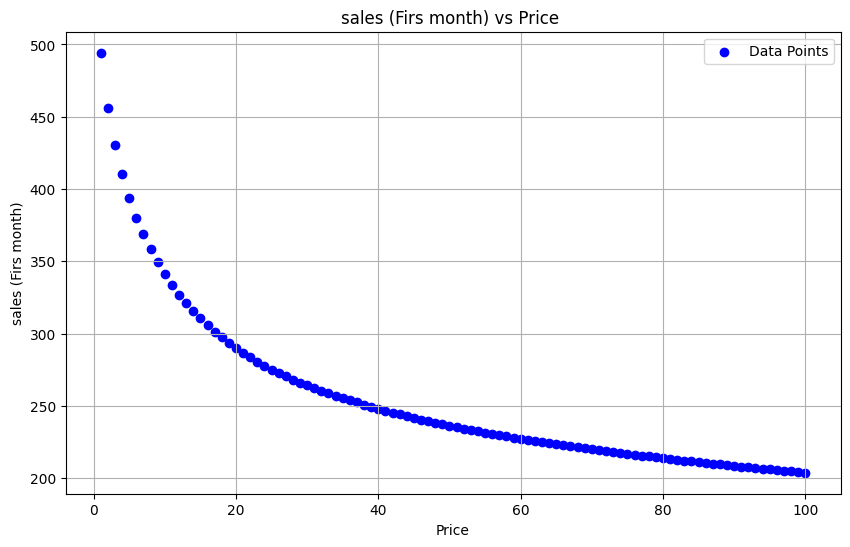

In [31]:
import matplotlib.pyplot as plt

# 假设 y 已经定义，df["price"] 已经存在
# 从 DataFrame 中获取价格数据
# price = np.expm1(df["price"].values)

# 确保 y 和 price 的长度一致
assert len(y) == len(price), "y 和 price 的长度不一致！"

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(x, predicted_sales, color='blue', label='Data Points')

# 设置标题和轴标签
plt.title('sales (Firs month) vs Price ')
plt.xlabel('Price')
plt.ylabel('sales (Firs month)')

# 添加图例
plt.legend()

# 添加网格线
plt.grid(True)

# 显示图形
plt.show()


In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 假設你的數據已經在這兩個列表中


# 計算一階導數
dy_dx = np.gradient(predicted_sales, 0.01)

# 繪製原始數據和微分圖
plt.figure(figsize=(12, 6))

# 原始數據圖
plt.subplot(1, 2, 1)
plt.plot(x, predicted_sales, 'b.', label='Data Points')
plt.xlabel('Price')
plt.ylabel('y')
plt.title('y 對 Price 的變化')
plt.legend()

# 微分圖
plt.subplot(1, 2, 2)
plt.plot(x, dy_dx, 'r-', label='dy/dx')
plt.xlabel('Price')
plt.ylabel("dy/dx")
plt.title('y 對 Price 的一階微分')
plt.legend()

plt.tight_layout()
plt.show()


ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

In [22]:
from torch.utils.tensorboard import SummaryWriter
import torch

# 確認設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 將模型和輸入張量移到相同設備
model = model.to(device)
sample_input = torch.randn(1, input_size).to(device)  # 假設 input_size 為模型的輸入尺寸

# 初始化 TensorBoard
writer = SummaryWriter()

# 將模型架構寫入 TensorBoard
writer.add_graph(model, sample_input)
writer.close()


In [24]:
!pip install torchsummary


In [25]:
from torchsummary import summary

# 假設模型和輸入尺寸已定義
model = model.to(device)
summary(model, input_size=(input_size,))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         283,648
              ReLU-2                 [-1, 1024]               0
       BatchNorm1d-3                 [-1, 1024]           2,048
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 320]         328,000
              ReLU-6                  [-1, 320]               0
       BatchNorm1d-7                  [-1, 320]             640
           Dropout-8                  [-1, 320]               0
            Linear-9                    [-1, 1]             321
Total params: 614,657
Trainable params: 614,657
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 2.34
Estimated Total Size (MB): 2.39
-------------------------------------------

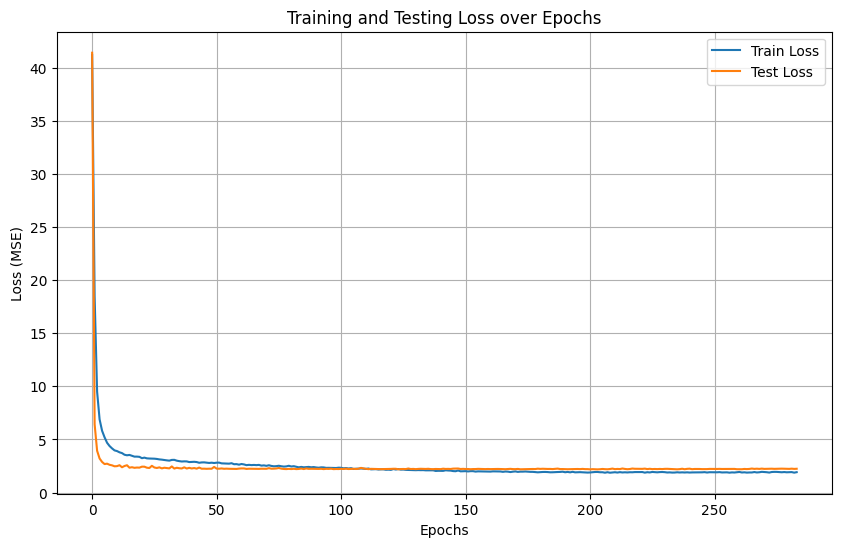

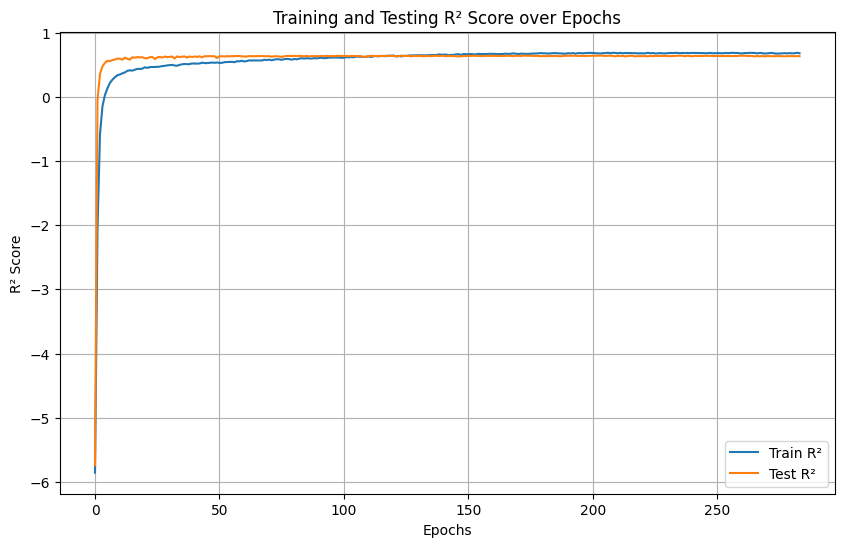

In [24]:
import matplotlib.pyplot as plt

# 訓練和測試損失
plt.figure(figsize=(10, 6))
plt.plot(metrics["train_loss"], label="Train Loss")
plt.plot(metrics["test_loss"], label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 訓練和測試 R²
plt.figure(figsize=(10, 6))
plt.plot(metrics["train_r2"], label="Train R²")
plt.plot(metrics["test_r2"], label="Test R²")
plt.xlabel("Epochs")
plt.ylabel("R² Score")
plt.title("Training and Testing R² Score over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
for index, item in enumerate(metrics["test_r2"]):
    if item == max(metrics["test_r2"]):
        print(index, item)

203 0.6438818148204258


In [31]:
import math
rmse = math.sqrt(2.177739245550973)
rmse

1.4757165193732071